## Semantic Segmentation With UNet

For this project I'll be training a UNet model on the task of  
semantic segmentation.

The dataset consists of people in clothing, and the masks are of
their outfits.

The dataset was obtained from Kaggle at the following [link](https://www.kaggle.com/datasets/rajkumarl/people-clothing-segmentation),  
the dataset is authored by Rajkumar Lakshmanamoorthy 

In [1]:
import tensorflow as tf
import PIL
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
MASKS_DIR = 'data/png_masks/MASKS/'
IMG_DIR = 'data/png_images/IMAGES/'

imgs = [x for x in os.listdir(IMG_DIR)]
masks = [x for x in os.listdir(MASKS_DIR)]

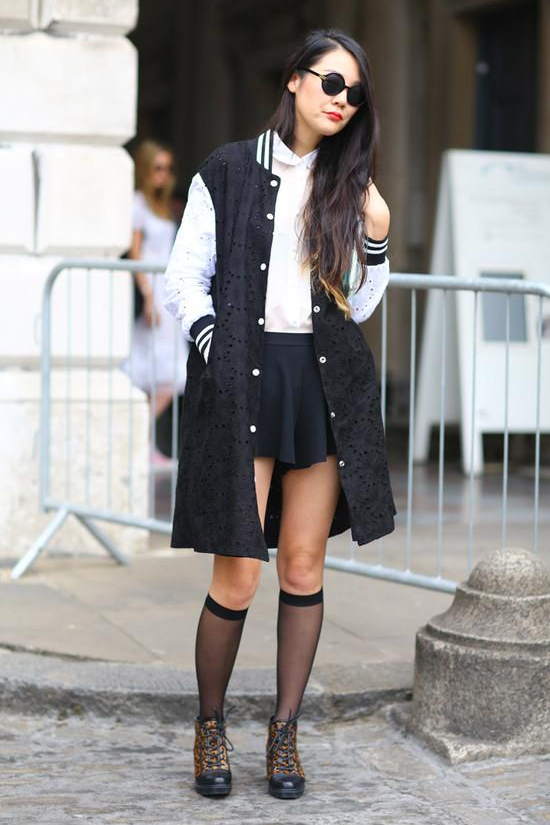

In [3]:
PIL.Image.open(f'{IMG_DIR}{imgs[0]}')

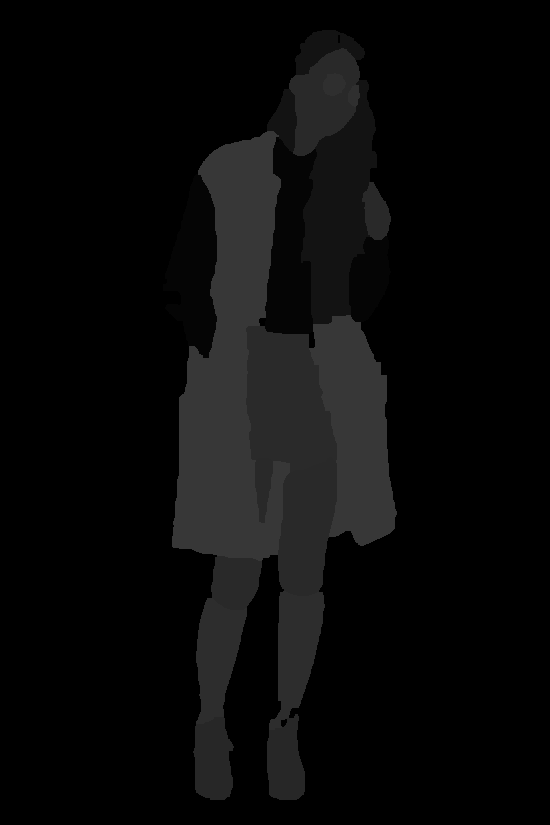

In [4]:
PIL.Image.open(f'{MASKS_DIR}{masks[0]}')

Let's now create our datasets, we'll load them in using OpenCV and resize them from their  
original size of 852x550 to 128x128

In [24]:
img_dataset = []
mask_dataset = []

for idx in range(len(imgs)):
    img = cv2.imread(f'{IMG_DIR}{imgs[idx]}',cv2.IMREAD_UNCHANGED)
    mask = cv2.imread(f'{MASKS_DIR}{masks[idx]}',cv2.IMREAD_UNCHANGED)
    img_resized = cv2.resize(img,(128,128))
    mask_resized = cv2.resize(mask,(128,128))

    img_dataset.append(img_resized)
    mask_dataset.append(mask_resized)

img_dataset = np.array(img_dataset)
mask_dataset = np.array(mask_dataset)

Let's take a look at our images the normalize the data

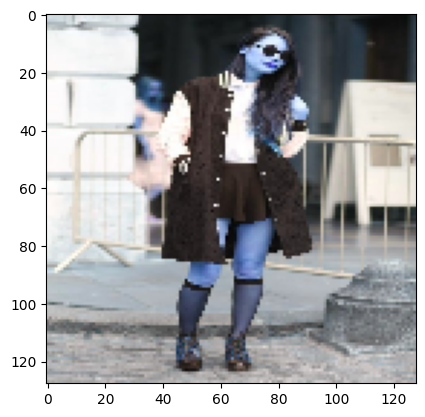

In [12]:
plt.imshow(img_dataset[0])

In [25]:
print(img_resized.min(),img_resized.max())

0 255


In [27]:
img_resized = img_resized/255

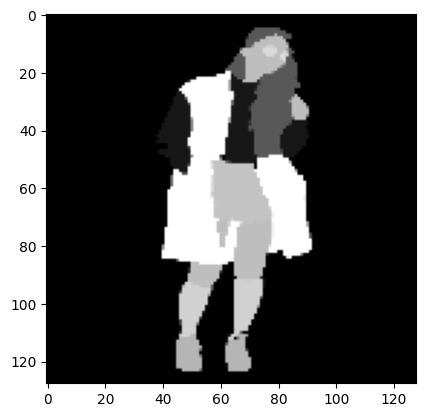

In [13]:
plt.imshow(mask_dataset[0],cmap='gray')

In [30]:
print(mask_dataset.min(),mask_dataset.max())

0 58


In [31]:
mask_dataset = mask_dataset/58

In [32]:
dataset = tf.data.Dataset.from_tensor_slices((img_dataset,mask_dataset))

In [33]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000
DATASET_SIZE = len(dataset)

train_dataset = dataset.take(int(DATASET_SIZE*0.8)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = dataset.skip(int(DATASET_SIZE*0.8)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Now that we've created our dataset, we can now move onto creating our model

We'll start by defining the helper functions necessary to create the model,  
we'll need a helper to create the downsampling and upsampling blocks for the  
encoder and decoder respectively

In [34]:
def downsample_block(prev_block,filters,kernel_size,dropout):
    x = tf.keras.layers.Conv2D(filters=filters,
                               kernel_size=kernel_size,
                               activation='relu',
                               padding='same')(prev_block)
    if dropout != None:
        x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Conv2D(filters=filters,
                               kernel_size=kernel_size,
                               activation='relu',
                               padding='same')(x)
    return x

In [35]:
def upsample_block(prev_block,skip_conn,filters,
                   kernel_size,dropout,strides):
    x = tf.keras.layers.Conv2DTranspose(filters=filters,
                                        kernel_size=kernel_size[0],
                                        activation='relu',
                                        strides=strides,
                                        padding='same')(prev_block)
    x = tf.keras.layers.Concatenate(axis=3)([x,skip_conn])
    x = tf.keras.layers.Conv2D(filters=filters,
                               kernel_size=kernel_size[1],
                               activation='relu',
                               padding='same')(x)
    if dropout != None:
        x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Conv2D(filters=filters,
                               kernel_size=kernel_size[1],
                               activation='relu',
                               padding='same')(x)
    return x

Now that we have our helpers we can create our UNet model

In [70]:
# First model iteration
def UNet(img_shape):

    filters = 32
    enc_kernel_size = 3
    dec_kernel_size = [2,3]

    img_in = tf.keras.layers.Input(shape=img_shape)

    # Encoder
    d1 = downsample_block(img_in,filters,enc_kernel_size,0.1)
    pool1 = tf.keras.layers.MaxPooling2D((2,2))(d1)
    
    d2 = downsample_block(pool1,2*filters,enc_kernel_size,0.1)
    pool2 = tf.keras.layers.MaxPooling2D((2,2))(d2)

    d3 = downsample_block(pool2,4*filters,enc_kernel_size,0.1)
    pool3 = tf.keras.layers.MaxPooling2D((2,2))(d3)

    d4 = downsample_block(pool3,8*filters,enc_kernel_size,0.1)
    pool4 = tf.keras.layers.MaxPooling2D((2,2))(d4)
    
    d5 = downsample_block(pool4,16*filters,enc_kernel_size,0.3)

    # Decoder
    u1 = upsample_block(d5,d4,8*filters,dec_kernel_size,0.2,2)
    u2 = upsample_block(u1,d3,4*filters,dec_kernel_size,0.2,2)
    u3 = upsample_block(u2,d2,2*filters,dec_kernel_size,0.2,2)
    u4 = upsample_block(u3,d1,filters,dec_kernel_size,0.2,2)

    out_layer = tf.keras.layers.Conv2D(filters=1,kernel_size=1,activation='sigmoid')(u4)

    return tf.keras.Model(inputs=img_in,outputs=out_layer,name='U-Net')

## Second model iteration
def UNet2(img_shape):

    filters = 48
    enc_kernel_size = 3
    dec_kernel_size = [2,3]

    img_in = tf.keras.layers.Input(shape=img_shape)
    
    # Data Augmentation
    aug_flip = tf.keras.layers.RandomFlip("horizontal_and_vertical")(img_in)
    aug_rotate = tf.keras.layers.RandomRotation(0.2)(aug_flip)

    # Encoder
    d1 = downsample_block(aug_rotate,filters,enc_kernel_size,0.1)
    pool1 = tf.keras.layers.MaxPooling2D((2,2))(d1)
    
    d2 = downsample_block(pool1,2*filters,enc_kernel_size,0.1)
    pool2 = tf.keras.layers.MaxPooling2D((2,2))(d2)

    d3 = downsample_block(pool2,4*filters,enc_kernel_size,0.1)
    pool3 = tf.keras.layers.MaxPooling2D((2,2))(d3)

    d4 = downsample_block(pool3,8*filters,enc_kernel_size,0.1)
    pool4 = tf.keras.layers.MaxPooling2D((2,2))(d4)
    
    d5 = downsample_block(pool4,16*filters,enc_kernel_size,0.1)
    pool5 = tf.keras.layers.MaxPooling2D((2,2))(d5)
    
    d6 = downsample_block(pool5,32*filters,enc_kernel_size,0.3)

    # Decoder
    u1 = upsample_block(d6,d5,16*filters,dec_kernel_size,0.2,2)
    u2 = upsample_block(u1,d4,8*filters,dec_kernel_size,0.2,2)
    u3 = upsample_block(u2,d3,4*filters,dec_kernel_size,0.2,2)
    u4 = upsample_block(u3,d2,2*filters,dec_kernel_size,0.2,2)
    u5 = upsample_block(u4,d1,filters,dec_kernel_size,0.2,2)

    out_layer = tf.keras.layers.Conv2D(filters=1,kernel_size=1,activation='sigmoid')(u5)

    return tf.keras.Model(inputs=img_in,outputs=out_layer,name='U-Net')

In [71]:
IMG_SHAPE = (128,128,3)
unet_model = UNet(IMG_SHAPE)

In [72]:
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 128, 128, 32  0           ['conv2d_19[0][0]']              
                                )                                                             

In [73]:
unet_model.compile(loss='binary_crossentropy',optimizer='adam',
                   metrics=['accuracy'])

With our model created, we can now move onto training

In [74]:
chkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='models/unet_clothing.h5',verbose=1,save_best_only=True)
cbs = [tf.keras.callbacks.EarlyStopping(patience=2,monitor='val_loss'),
       tf.keras.callbacks.TensorBoard(log_dir='logs'),
       chkpointer]

In [75]:
history = unet_model.fit(train_dataset,validation_data=val_dataset,
                         epochs=25,callbacks=[cbs])

Epoch 1/25
13/13 [==============================] - ETA: 0s - loss: 1.5313 - accuracy: 0.7200 
Epoch 1: val_loss improved from inf to 0.92360, saving model to models\unet_clothing.h5
13/13 [==============================] - 239s 17s/step - loss: 1.5313 - accuracy: 0.7200 - val_loss: 0.9236 - val_accuracy: 0.7614
Epoch 2/25
13/13 [==============================] - ETA: 0s - loss: 0.5341 - accuracy: 0.7270 
Epoch 2: val_loss improved from 0.92360 to 0.33169, saving model to models\unet_clothing.h5
13/13 [==============================] - 209s 16s/step - loss: 0.5341 - accuracy: 0.7270 - val_loss: 0.3317 - val_accuracy: 0.7640
Epoch 3/25
13/13 [==============================] - ETA: 0s - loss: 0.3242 - accuracy: 0.7613 
Epoch 3: val_loss improved from 0.33169 to 0.32056, saving model to models\unet_clothing.h5
13/13 [==============================] - 207s 16s/step - loss: 0.3242 - accuracy: 0.7613 - val_loss: 0.3206 - val_accuracy: 0.7619
Epoch 4/25
11/13 [========================>.....] 

KeyboardInterrupt: 

<Axes: >

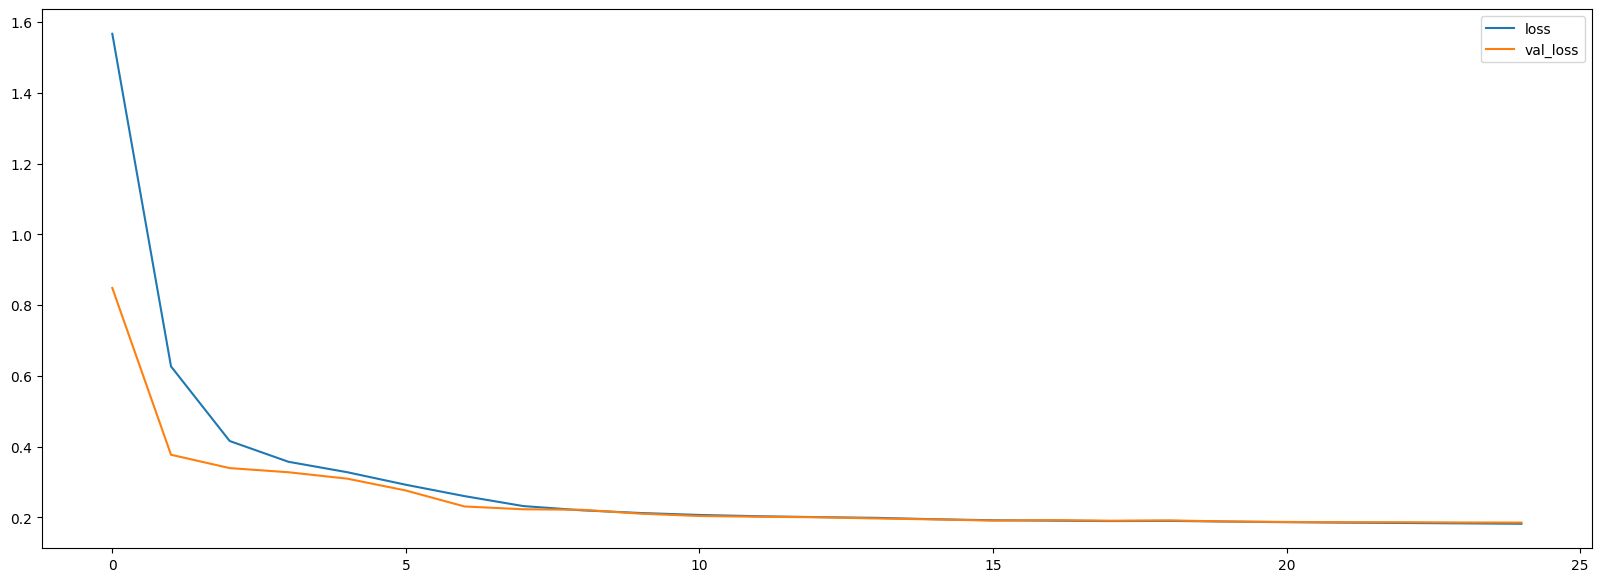

In [76]:
import pandas as pd

history_df = pd.DataFrame(history.history)
history_df[['loss','val_loss']].plot(figsize=(20,7))


From the plot above, the model looks to be performing well, it doesn't look to be  
overfitting the training data since the gap between the validation loss and training loss  
is not large, although the loss itself does seem to be stuck around 0.2 which may indicate  
that the model has high bias and may need more complexity

Let's see how the accuracy changed over the epochs

<Axes: >

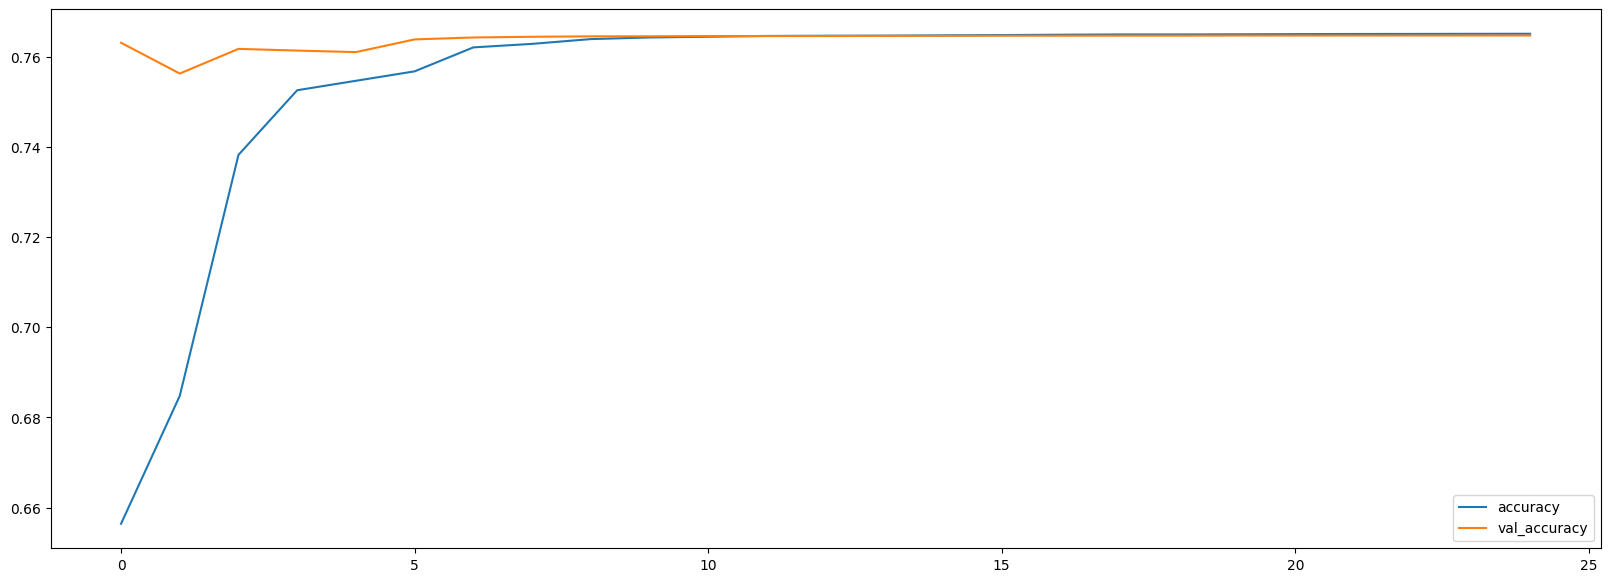

In [66]:
history_df[['accuracy','val_accuracy']].plot(figsize=(20,7))

The accuracy seems to be hitting a ceiling at 76%, this isn't terrible however it may improve  
if we increase the complexity of the model

Let's create some plots using our validation data

In [51]:
val_imgs = img_dataset[len(train_dataset):]
val_masks = mask_dataset[len(train_dataset):]

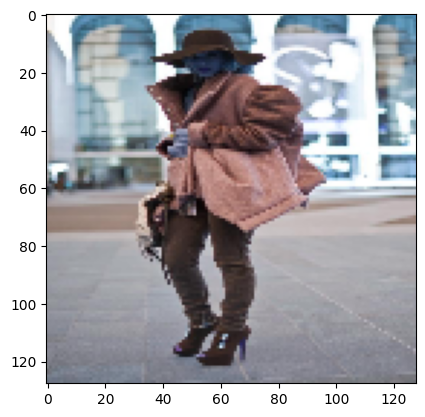

In [67]:
plt.imshow(val_imgs[2])

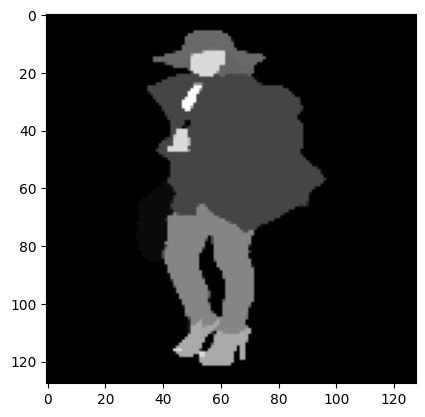

In [68]:
plt.imshow(val_masks[2],cmap='gray')

In [62]:
pred_masks = unet_model.predict(val_imgs)
pred_masks.shape

31/31 [==============================] - 18s 574ms/step


(987, 128, 128, 1)

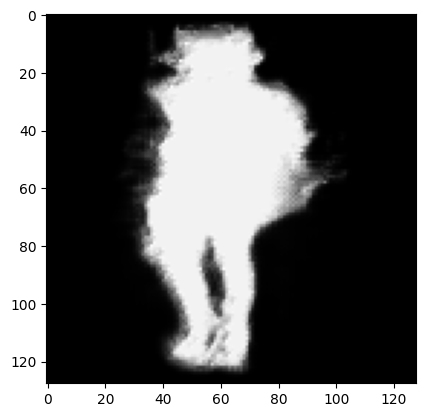

In [69]:
plt.imshow(pred_masks[2],cmap='gray')

The model looks to be producing decent masks, although they are lacking in the  
internal details that the true masks possess, only capturing the outline